# Vision Transformer Cifar-10

In this notebook, I implement a vision transformer, as described in this [paper](https://arxiv.org/pdf/2010.11929v2.pdf). Transformers have been widely used in NLP but can also be used in computer vision tasks, where they typically achieve better performance than convolution based models on very large datasets while CNNs win out on smaller datasets.

I wasn't able to fully train the model in this notebook as I am running out of google colab credits for this month. It seemed to perform well on the initial couple of epochs and a different model trained up to ~70% accuracy before I had to restart. I am interested to see how it performs when I am able to test it and see if it is able to beat the ResNet model I implemented on the Cifar dataset.

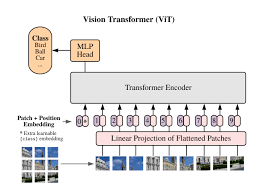

## Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import time
import math
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torchvision.transforms as transforms

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Get Data

In [ ]:
#I took data loader, visualisation and test code from here
#https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

transform = transforms.Compose(
    [transforms.ToTensor(),
     #transforms.Lambda(nn.ZeroPad2d(4)),
     #transforms.RandomCrop(32),
     transforms.RandomHorizontalFlip(),
     #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

batch_size = 128
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1, drop_last = True)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=1, drop_last = True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Embedding

This embedding turns an image `(batch_size,channels,height,width)` into `(batch_size,patches+1,patch_height*patch_width*patch_channels)`, where patches+1 in the second dimension is due to the addition of the start token

In [ ]:
class Embedding(nn.Module):
    def __init__(self,d_model):
      super(Embedding, self).__init__()
      self.linear = nn.Linear(48,d_model,device=device)
      #learnable start token
      #we append this token to the start of every input to model and then we use this token position as model output
      self.new_token = nn.Parameter(torch.empty((d_model),device=device))
    def forward(self,x):
      #get patches of image (kind of similar to a how a convolution works)
      #assertions are commented out for efficiency
      x = x.unfold(-1,4,4).unfold(-3,4,4).flatten(-4,-3).permute(0,2,1,3,4).flatten(-3)
      x = F.relu(self.linear(x))
      sh = list(x.shape)
      sh[-2]=1
      #test_tensor = x.clone()
      new_token_stack = self.new_token.expand(sh)
      x = torch.cat((new_token_stack,x),dim=-2)
      #ensure everything is working correctly
      #assert torch.sum(x[:,0]-self.new_token) == 0
      #assert torch.sum(test_tensor-x[:,1:,:])==0
      return x

dataiter = iter(trainloader)
images, labels = next(dataiter)
model = Embedding(512)
print(images.shape)
print(model(images.to(device)).shape)

torch.Size([128, 3, 32, 32])
torch.Size([128, 65, 512])


## Positional Encoding (1d)

In [ ]:
#copied this function from the annotated transformer
#https://nlp.seas.harvard.edu/annotated-transformer/
class PositionalEncoding(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens in the sequence.
        The positional encodings have the same dimension as the embeddings, so that the two can be summed.
        Here, we use sine and cosine functions of different frequencies.
    .. math:
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=5000).
    Examples:
        >>> pos_encoder = PositionalEncoding(d_model)
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

## Transformer Block

Each `Block` consists of an attention layer and a fully connected layer. Each layer is followed by a residual connection such that they can each be described by `y = F(x) + x`. The output from this layer is then normalised using layer normalization.

In [ ]:
class Block(nn.Module):
  def __init__(self,d_model,dropout):
    super(Block, self).__init__()
    self.mha = nn.MultiheadAttention(d_model, 4,batch_first=True,dropout=dropout)
    self.ln1 = nn.LayerNorm([65,d_model])
    self.fc2 = nn.Linear(d_model,3072)
    self.fc3 = nn.Linear(3072, d_model)
    self.ln2 = nn.LayerNorm([65,d_model])

  def forward(self,x):
    res = x.clone()
    x = self.mha(x,x,x)[0]
    x = self.ln1(x+res)
    res = x.clone()
    x = F.gelu(self.fc2(x))
    x = self.ln2(self.fc3(x)+res)
    return x

## Create Model

In [ ]:
class AttentionNet(nn.Module):
    def __init__(self):
        super(AttentionNet, self).__init__()
        d_model = 768
        dropout = .1

        self.b1 = Block(d_model,dropout)
        self.b2 = Block(d_model,dropout)
        self.b3 = Block(d_model,dropout)
        self.b4 = Block(d_model,dropout)
        self.b5 = Block(d_model,dropout)
        self.b6 = Block(d_model,dropout)

        self.emb = Embedding(d_model)
        self.pos = PositionalEncoding(d_model, dropout)

        self.fc3 = nn.Linear(d_model,d_model)
        self.fc4 = nn.Linear(d_model,d_model)
        self.fc5 = nn.Linear(d_model,256)
        self.fc6 = nn.Linear(256, 10)

    def forward(self, x):

        x = self.emb(x)
        x = self.pos(x)

        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        x = self.b4(x)
        x = self.b5(x)
        x = self.b6(x)

        x = x[:,0]
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x

## Train

In [ ]:
model = AttentionNet().to(device)
loss_fn = nn.CrossEntropyLoss()

We can see below that the model does train. It is slower to train than the ResNet20 model I implemented in another notebook, due to its lower inductive bias (assumptions made during creation of the model), but this is also what should allow it to be more accurate when it is trained.

I haven't trained it for long as I am running low on Google Colab credits, but when I build up some credits, I will train the model for longer. I am interested to see how it performs relative to convolution based models.

In [ ]:
learning_rate=.03
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum = .9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,30000)

def test_():
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in testloader:
            outputs = model(inputs.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
    print(correct/total)
    return correct/total

def train_one_epoch():
    for inputs, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        loss = loss_fn(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        scheduler.step()

for x in range(100):
  train_one_epoch()
  test_()
  print(scheduler.get_last_lr())
  torch.save(model.state_dict(), f'/content/drive/MyDrive/vision_transformer_{x}')

0.23707932692307693
[0.029987492015138072]
0.2631209935897436
[0.02994998892051045]
0.2916666666666667
[0.029887553261202383]


KeyboardInterrupt: ignored